In [2]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import fetch_mldata
import matplotlib.pyplot as plt


In [3]:
def euclidean_distance(X, Y):
    return np.sqrt(
            np.sum(X**2, axis=1)[:, np.newaxis] +
            np.sum(Y**2, axis=1) - 2 * X.dot(Y.T)
            )


def cosine_distance(X, Y):
    X = X.astype('float64') / np.sqrt(np.sum(X**2, axis=1)[:, np.newaxis])
    Y = Y.astype('float64') / np.sqrt(np.sum(Y**2, axis=1)[:, np.newaxis])
    return 1 - X.dot(Y.T)

In [4]:
class KNNClassifier:
    def __init__(self, k, strategy, metric, weights, test_block_size):
        self.k = k
        self.strategy = strategy
        self.metric = metric
        self.weights = weights
        self.test_block_size = test_block_size

    def fit(self, X, y):
        if(self.strategy == 'my_own'):
            self.X = X
            self.y = y
        else:
            self.y = y
            self.sklearn_knn = NearestNeighbors(
                    n_neighbors=self.k, algorithm=self.strategy,
                    metric=self.metric).fit(X)

    def find_kneighbors(self, X, return_distance):
        iter_num = np.size(X, 0) // self.test_block_size
        if(np.size(X, 0) % self.test_block_size):
            iter_num += 1
        ind_list = list()
        if(return_distance):
            dist_list = list()
        for i in range(iter_num):
            ind_beg = self.test_block_size * i
            ind_end = self.test_block_size * (i + 1)
            if(self.strategy == 'my_own'):
                if(self.metric == 'euclidean'):
                    distance_matrix = euclidean_distance(X[ind_beg:ind_end], self.X)
                elif(self.metric == 'cosine'):
                    distance_matrix = cosine_distance(X[ind_beg:ind_end], self.X)
                k_ind_matrix = np.argsort(distance_matrix, axis=1)[:, :self.k]
                ind_list.append(k_ind_matrix)
                if(return_distance):
                    dist_list.append(distance_matrix[
                        np.arange(np.size(k_ind_matrix, 0))[:, np.newaxis],
                        k_ind_matrix])
            else:
                if(return_distance):
                    dist, ind = self.sklearn_knn.kneighbors(
                    X[ind_beg:ind_end], n_neighbors=self.k,
                    return_distance=return_distance)
                    dist_list.append(dist)
                    ind_list.append(ind)
                else:
                    ind_list.append(
                        self.sklearn_knn.kneighbors(
                                X[ind_beg:ind_end], n_neighbors=self.k,
                                return_distance=return_distance))
        if(return_distance):
            return np.concatenate(dist_list), np.concatenate(ind_list)
        else:
            return np.concatenate(ind_list)

    def predict(self, X):
        if(not self.weights):
            k_ind_matrix = self.find_kneighbors(X, False)
            k_y = self.y[k_ind_matrix]
            result_matrix = np.empty(np.size(X, 0))
            for j in range(np.size(X, 0)):
                result_matrix[j] = np.argmax(np.bincount(k_y[j]))
            return result_matrix
        else:
            distance_matrix, k_ind_matrix = self.find_kneighbors(X, True)
            k_y = self.y[k_ind_matrix]
            result_matrix = np.empty(np.size(X, 0))
            for j in range(np.size(X, 0)):
                result_matrix[j] = np.argmax(
                        np.bincount(
                                k_y[j],
                                weights=1 / (distance_matrix[j] + 1e-5)
                                )
                        )
            return result_matrix


In [5]:
def kfold(n, n_folds):
    ind_array = np.arange(n)
    np.random.shuffle(ind_array)
    fold_size = n // n_folds
    left = n - fold_size * n_folds
    folds_list = list()
    for i in range(left):
        beg_ind = (fold_size + 1) * i
        end_ind = (fold_size + 1) * (i + 1)
        folds_list.append((
                np.hstack((ind_array[:beg_ind], ind_array[end_ind:])),
                ind_array[beg_ind: end_ind]))
    for i in range(n_folds - left):
        beg_ind = (fold_size + 1) * left + fold_size * i
        end_ind = (fold_size + 1) * left + fold_size * (i + 1)
        folds_list.append((
                np.hstack((ind_array[:beg_ind], ind_array[end_ind:])),
                ind_array[beg_ind: end_ind]))
    return folds_list


def knn_cross_val_score(X, y, k_list, score, cv, **kwargs):
    if (cv is None):
        cv = kfold(np.size(X, 0), 3)
    score_dict = dict()
    curr_ind = list()
    weight_flag = kwargs['weights']
    if(weight_flag):
        curr_weights = list()
    curr_score = np.empty(len(cv))
    for j in range(len(cv)):
        classifier = KNNClassifier(k_list[len(k_list) - 1], **kwargs)
        classifier.fit(X[cv[j][0]], y[cv[j][0]])
        y_knn = classifier.predict(X[cv[j][1]])
        if(weight_flag):
            curr_w, curr_i = classifier.find_kneighbors(X[cv[j][1]], True)
            curr_weights.append(curr_w)
            curr_ind.append(curr_i)
        else:
            curr_i = classifier.find_kneighbors(X[cv[j][1]], False)
            curr_ind.append(curr_i)
        if(score == 'accuracy'):
            num_diff = np.sum(y_knn == y[cv[j][1]])
            curr_score[j] = num_diff / np.size(y_knn)
    score_dict[k_list[len(k_list) - 1]] = curr_score
    for i in range(len(k_list) - 2, -1, -1):
        k_diff = k_list[i + 1] - k_list[i]
        curr_score = np.empty(len(cv))
        for j in range(len(cv)):
            curr_ind[j] = curr_ind[j][:, :-k_diff]
            if(weight_flag):
                curr_weights[j] = curr_weights[j][:, :-k_diff]
                y_ind = y[cv[j][0]][curr_ind[j]]
                y_knn = np.empty(np.size(y_ind, 0))
                for k in range(np.size(y_ind, 0)):
                    y_knn[k] = np.argmax(
                            np.bincount(
                                    y_ind[k],
                                    weights=1 / (curr_weights[j][k] + 1e-5)
                                    )
                            )
            else:
                y_ind = y[cv[j][0]][curr_ind[j]]
                y_knn = np.empty(np.size(y_ind, 0))
                for k in range(np.size(y_ind, 0)):
                    y_knn[k] = np.argmax(np.bincount(y_ind[k]))
            if(score == 'accuracy'):
                num_diff = np.sum(y_knn == y[cv[j][1]])
                curr_score[j] = num_diff / np.size(y_knn)
        score_dict[k_list[i]] = curr_score
    return score_dict

In [6]:
mnist = fetch_mldata("MNIST original")
X = mnist.data # np.array размера (70000, 784)
y = mnist.target.astype('int64') # np.array размера (70000,)
X_train = X[:60000]
X_test = X[60000:]
y_train = y[:60000]
y_test = y[60000:]

Тест №1

In [ ]:
#сформируем подмножества признаков нужного размера
feature_ind = np.arange(np.size(X, 0))
ind_10 = feature_ind[:10]
ind_20 = feature_ind[:20]
ind_100 = feature_ind[:100]
ind_list = [ind_10, ind_20 , ind_100]
strategy_list = ['my_own', 'brute', 'kd_tree', 'ball_tree']
for ind in ind_list:
    print('number of features:', np.size(ind))
    for strat in strategy_list:
        print(strat)
        knn = KNNClassifier(k=5, strategy=strat, metric='euclidean', weights=False, test_block_size=1000)
        knn.fit(X_train[:, ind], y_train)
        %time knn.predict(X_test[:, ind])

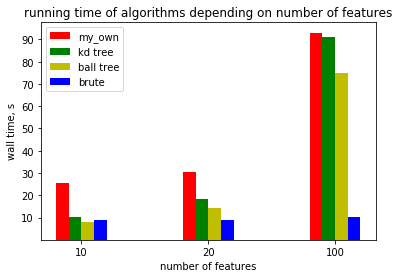

In [31]:
time_my_own = np.array([25.7, 30.5, 93])
time_brute = np.array([8.88, 8.96, 10.3])
time_kd = np.array([10.1, 18.3, 91])
time_ball = np.array([7.77, 14.2, 75])
fig, ax = plt.subplots()
index = np.array([1, 2, 3])
bar_width = 0.1

rects1 = ax.bar(index, time_my_own, bar_width, color='r', label='my_own')
rects2 = ax.bar(index + bar_width, time_kd, bar_width, color='g', label='kd tree')
rects3 = ax.bar(index + 2 * bar_width, time_ball, bar_width, color='y', label='ball tree')
rects4 = ax.bar(index + 3 * bar_width, time_brute, bar_width, color='b', label='brute') 
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels((10, 20, 100))
ax.set_xlabel('number of features')
ax.set_yticks(np.arange(10, 100, 10))
ax.set_ylabel('wall time, s')
ax.set_title('running time of algorithms depending on number of features')
ax.legend()
fig.savefig('img1.pdf')

In [33]:
k_list = [i for i in range(1, 11)]
arg_dict = dict()
arg_dict['strategy'] = 'brute'
arg_dict['metric'] = 'euclidean'
arg_dict['weights'] = False
arg_dict['test_block_size'] = 1000
result_dict = knn_cross_val_score(X, y, k_list, score='accuracy', cv=None, **arg_dict)
print(result_dict)

{10: array([0.96588669, 0.96635666, 0.96528522]), 9: array([0.96661524, 0.96695667, 0.96554236]), 8: array([0.96652953, 0.9679424 , 0.9663138 ]), 7: array([0.96755807, 0.96837098, 0.96691381]), 6: array([0.96755807, 0.96892813, 0.96729953]), 5: array([0.96961515, 0.96897099, 0.96858527]), 4: array([0.96910088, 0.96909956, 0.96849955]), 3: array([0.97025799, 0.96999957, 0.97055672]), 2: array([0.96455816, 0.96459949, 0.96404234]), 1: array([0.97081512, 0.96978528, 0.96879955])}


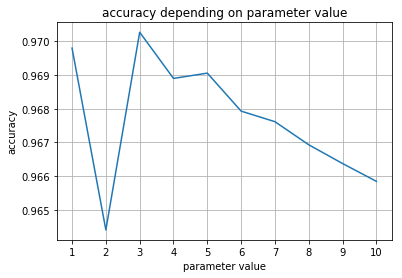

In [37]:
copy_result_dict = result_dict.copy()
for key in copy_result_dict:
    copy_result_dict[key] = copy_result_dict[key].mean()
copy_result_dict
k_arr = np.arange(1, 11)
acc_list = list()
for k in k_arr:
    acc_list.append(copy_result_dict[k])
acc_arr = np.array(acc_list)
plt.plot(k_arr, acc_arr)
plt.grid()
plt.xticks(k_list)
plt.xlabel('parameter value')
plt.ylabel('accuracy')
plt.title('accuracy depending on parameter value')
plt.savefig('img3.pdf')

Для k=3 проведем сравнение использования разных метрик (по времени и по точности)

In [7]:
arg_dict = dict()
arg_dict['strategy'] = 'brute'
arg_dict['weights'] = False
arg_dict['test_block_size'] = 1000
print('euclidean')
arg_dict['metric'] = 'euclidean'
%time result_dict_eucl = knn_cross_val_score(X, y, [1, 2, 3], score='accuracy', cv=None, **arg_dict)
print(result_dict_eucl)
print('cosine')
arg_dict['metric'] = 'cosine'
%time result_dict_cosine = knn_cross_val_score(X, y, [1, 2, 3], score='accuracy', cv=None, **arg_dict)
print(result_dict_cosine)

euclidean
CPU times: user 7min 11s, sys: 48.6 s, total: 8min
Wall time: 4min 50s
{3: array([0.97025799, 0.97141388, 0.97077101]), 2: array([0.96460101, 0.9648995 , 0.96447092]), 1: array([0.97068655, 0.97047101, 0.97038529])}
cosine
CPU times: user 8min 11s, sys: 1min 25s, total: 9min 36s
Wall time: 5min 22s
{3: array([0.9754007 , 0.97317105, 0.9751425 ]), 2: array([0.9714151 , 0.97021386, 0.97089958]), 1: array([0.97411503, 0.97364248, 0.97501393])}


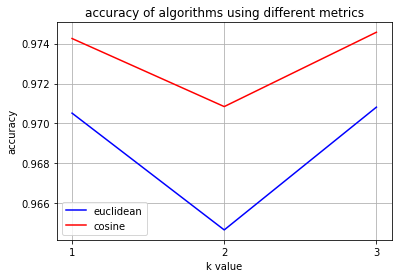

In [11]:
k_arr = np.array([1, 2, 3])
eucl_arr = np.empty((3))
eucl_arr[0] = result_dict_eucl[1].mean()
eucl_arr[1] = result_dict_eucl[2].mean()
eucl_arr[2] = result_dict_eucl[3].mean()
cosine_arr = np.empty((3))
cosine_arr[0] = result_dict_cosine[1].mean()
cosine_arr[1] = result_dict_cosine[2].mean()
cosine_arr[2] = result_dict_cosine[3].mean()
fig, ax = plt.subplots()
bar_width = 0.5
ax.plot(k_arr, eucl_arr, color='b', label='euclidean')
ax.plot(k_arr, cosine_arr, color='r', label='cosine')
plt.xticks([1, 2, 3])
plt.legend()
plt.xlabel('k value')
plt.ylabel('accuracy')
plt.title('accuracy of algorithms using different metrics')
plt.grid()
plt.savefig('img4.pdf')

In [ ]:
feature_ind = np.arange(np.size(X, 0))
ind_10 = feature_ind[:10]   
knn = KNNClassifier(k=5, strategy='my_own', metric='euclidean', weights=False, test_block_size=1000)
knn.fit(X_train[:, ind_10], y_train)
%timeit knn.predict(X_test[:, ind_10])

In [23]:
feature_ind = np.arange(np.size(X, 0))
ind_3 = feature_ind[:3]
ind_5 = feature_ind[:5]
ind_7 = feature_ind[:7]
ind_9 = feature_ind[:9]
ind_list = [ind_3, ind_5, ind_7, ind_9]
strategy_list = ['my_own', 'brute', 'kd_tree', 'ball_tree']
for ind in ind_list:
    print('number of features:', np.size(ind))
    for strat in strategy_list:
        print(strat)
        knn = KNNClassifier(k=5, strategy=strat, metric='euclidean', weights=False, test_block_size=1000)
        knn.fit(X_train[:, ind], y_train)
        %time knn.predict(X_test[:, ind])

number of features: 3
my_own
CPU times: user 18.8 s, sys: 4.29 s, total: 23.1 s
Wall time: 23.4 s
brute
CPU times: user 9.21 s, sys: 3.22 s, total: 12.4 s
Wall time: 8.96 s
kd_tree
CPU times: user 4.42 s, sys: 0 ns, total: 4.42 s
Wall time: 4.42 s
ball_tree
CPU times: user 3.84 s, sys: 0 ns, total: 3.84 s
Wall time: 3.84 s
number of features: 5
my_own
CPU times: user 19.5 s, sys: 4.32 s, total: 23.8 s
Wall time: 23.8 s
brute
CPU times: user 9.14 s, sys: 3.25 s, total: 12.4 s
Wall time: 8.95 s
kd_tree
CPU times: user 6.15 s, sys: 0 ns, total: 6.15 s
Wall time: 6.15 s
ball_tree
CPU times: user 5.1 s, sys: 0 ns, total: 5.1 s
Wall time: 5.1 s
number of features: 7
my_own
CPU times: user 20.2 s, sys: 4.2 s, total: 24.4 s
Wall time: 24.4 s
brute
CPU times: user 9.36 s, sys: 3.08 s, total: 12.4 s
Wall time: 8.97 s
kd_tree
CPU times: user 7.78 s, sys: 0 ns, total: 7.78 s
Wall time: 7.78 s
ball_tree
CPU times: user 6.39 s, sys: 43 µs, total: 6.39 s
Wall time: 6.61 s
number of features: 9
my_own

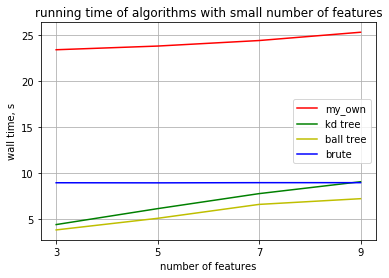

In [30]:
time_my_own = np.array([23.4, 23.8, 24.4, 25.3])
time_brute = np.array([8.96, 8.95, 8.97, 8.97])
time_kd = np.array([4.42, 6.15, 7.78, 9.07])
time_ball = np.array([3.84, 5.1, 6.61, 7.23])
fig, ax = plt.subplots()
index = np.array([3, 5, 7, 9])

rects1 = ax.plot(index, time_my_own, color='r', label='my_own')
rects2 = ax.plot(index, time_kd, color='g', label='kd tree')
rects3 = ax.plot(index, time_ball, color='y', label='ball tree')
rects4 = ax.plot(index, time_brute, color='b', label='brute') 
ax.set_xticks([3, 5, 7, 9])
ax.set_xlabel('number of features')
ax.set_ylabel('wall time, s')
ax.set_title('running time of algorithms with small number of features')
ax.legend()
ax.grid()
fig.savefig('img2.pdf')

In [22]:
feature_ind = np.arange(np.size(X, 0))
ind = feature_ind[:10]
strategy_list = ['my_own', 'brute', 'kd_tree', 'ball_tree']
for strat in strategy_list:
    print(strat)
    knn = KNNClassifier(k=5, strategy=strat, metric='euclidean', weights=False, test_block_size=1000)        
    knn.fit(X_train[:, ind], y_train)
    %time knn.predict(X_test[:, ind])

my_own
CPU times: user 21.6 s, sys: 4.4 s, total: 26 s
Wall time: 26 s
brute
CPU times: user 10 s, sys: 3.37 s, total: 13.4 s
Wall time: 9.8 s
kd_tree
CPU times: user 11.3 s, sys: 6.18 ms, total: 11.3 s
Wall time: 11.3 s
ball_tree
CPU times: user 8.2 s, sys: 0 ns, total: 8.2 s
Wall time: 8.28 s


In [54]:
arg_dict = dict()
arg_dict['strategy'] = 'brute'
arg_dict['test_block_size'] = 1000
arg_dict['metric'] = 'cosine'
print('weighted')
arg_dict['weights'] = True
cv = kfold(60000, 3)
%time result_dict_w = knn_cross_val_score(X, y, [3], score='accuracy', cv=cv, **arg_dict)
print(result_dict_eucl)
print('not weighted')
arg_dict['weights'] = False
%time result_dict_nw = knn_cross_val_score(X, y, [3], score='accuracy', cv=cv, **arg_dict)


weighted
CPU times: user 5min 37s, sys: 59.3 s, total: 6min 37s
Wall time: 3min 37s
{3: array([0.97365, 0.9759 , 0.9744 ])}
not weighted
CPU times: user 5min 37s, sys: 57.6 s, total: 6min 35s
Wall time: 3min 36s


In [58]:
print(result_dict_nw[3].mean())
print(result_dict_w[3].mean())


0.9739166666666667
0.9747166666666667


In [242]:
knn = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [159]:
acc = np.sum(y_pred == y_test) / np.size(y_test, 0)
acc

In [161]:
from sklearn.metrics import confusion_matrix
conf_bold = confusion_matrix(y_test, y_pred)


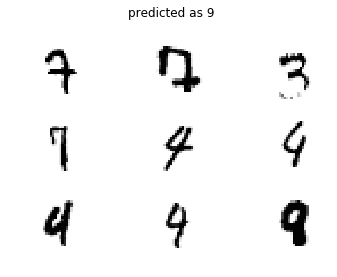

In [60]:
y_ind = np.arange(10000)
i_arr = np.arange(10)
i = 9
test = y_test != i
pred = y_pred == i
curr = test * pred
i_rec = y_ind[curr]
z = np.arange(np.size(i_rec))
np.random.shuffle(z)
i_rec_9 = i_rec[z[:10]]
fig = plt.figure()
for j in range(1, 10):
    ax = fig.add_subplot(3, 3, j)
    plt.imshow(X_test[i_rec_9[j]].reshape(28, 28), cmap="Greys")
    plt.axis('off')
fig.suptitle('predicted as 9')
plt.savefig('img09.pdf')

Эксперимент №5. Кросс-валидация.

In [11]:
cv = kfold(np.size(X_train, 0), 3)

In [64]:
i_list_rot = list()
d_list_rot = list()

rot_list = [-10, 10]
for rot in rot_list:
    curr_d_list = list()
    curr_i_list = list()
    for j in range(len(cv)):
        X_tr = X_train[cv[j][0]]
        y_tr = y_train[cv[j][0]]
        X_tst = X_train[cv[j][1]]
        y_tst = y_train[cv[j][1]]
        new_X = np.empty(np.shape(X_tr))
        for i in range(np.size(X_tr, 0)):
            img = X_tr[i].reshape(28, 28)
            new_img = rotate(img, rot)
            new_X[i] = new_img.flatten()
        knn = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
        knn.fit(new_X, y_tr)
        d, i = knn.find_kneighbors(X_tst, True)
        curr_i_list.append(i)
        curr_d_list.append(d)
    i_list_rot.apend(curr_i_list.copy())
    d_list_rot.append(curr_d_list.copy())

In [ ]:
i_list_0 = list()
d_list_0 = list()

for j in range(len(cv)):
    X_tr = X_train[cv[j][0]]
    y_tr = y_train[cv[j][0]]
    X_tst = X_train[cv[j][1]]
    y_tst = y_train[cv[j][1]]
    knn = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
    knn.fit(X_tr, y_tr)
    d, i = knn.find_kneighbors(X_tst, True)
    i_list_0.append(i)
    d_list_0.append(d)

In [69]:
from scipy.ndimage import shift

d_list_sh = list()
i_list_sh = list()

sh_list = [[1, 0], [-1, 0], [0, 1], [0, -1]]

for i in sh_list:
    curr_d_list = list()
    curr_i_list = list()
    for j in range(len(cv)):
        X_tr = X_train[cv[j][0]]
        y_tr = y_train[cv[j][0]]
        X_tst = X_train[cv[j][1]]
        y_tst = y_train[cv[j][1]]
        new_X = np.empty(np.shape(X_tr))
        for i in range(np.size(X_tr, 0)):
            img = X_tr[i].reshape(28, 28)
            new_img = shift(img, [1, 0])
            new_X[i] = new_img.flatten()
        knn = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
        knn.fit(new_X, y_tr)
        d, i = knn.find_kneighbors(X_tst, True)
        curr_i_list.append(i)
        curr_d_list.append(d)
    d_list_sh.append(curr_d_list.copy())
    i_list_sh.append(curr_i_list.copy())

In [57]:
from scipy.ndimage.filters import gaussian_filter

i_list_gauss = list()
d_list_gauss = list()

for j in range(len(cv)):
    X_tr = X_train[cv[j][0]]
    y_tr = y_train[cv[j][0]]
    X_tst = X_train[cv[j][1]]
    y_tst = y_train[cv[j][1]]
    new_X = np.empty(np.shape(X_tr))
    for i in range(np.size(X_tr, 0)):
        img = X_tr[i].reshape(28, 28)
        new_img = gaussian_filter(img, sigma=1)
        new_X[i] = new_img.flatten()
    knn = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
    knn.fit(new_X, y_tr)
    d, i = knn.find_kneighbors(X_tst, True)
    i_list_gauss.append(i)
    d_list_gauss.append(d)

In [78]:
full_list_i = list()
full_list_d = list()

sh_list = [[1, 0], [-1, 0], [0, 1], [0, -1]]
rot_list = [-10, 10]
for sh in sh_list:
    for rot in rot_list:
        curr_list_d = list()
        curr_list_i = list()
        for j in range(len(cv)):
            X_tr = X_train[cv[j][0]]
            y_tr = y_train[cv[j][0]]
            X_tst = X_train[cv[j][1]]
            y_tst = y_train[cv[j][1]]
            new_X = np.empty(np.shape(X_tr))
            for i in range(np.size(X_tr, 0)):
                img = X_tr[i].reshape(28, 28)
                new_img = shift(img, sh)
                new_img = rotate(new_img, rot)
                new_img = gaussian_filter(new_img, sigma=1)
                new_X[i] = new_img.flatten()
            knn = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
            knn.fit(new_X, y_tr)
            d, i = knn.find_kneighbors(X_tst, True)
            curr_list_i.append(i)
            curr_list_d.append(d)
        full_list_i.append(curr_list_i.copy())
        full_list_d.append(curr_list_d.copy())

In [83]:
k = 3
rez_list = list()
for j in range(len(cv)):
    X_tr = X_train[cv[j][0]]
    y_tr = y_train[cv[j][0]]
    X_tst = X_train[cv[j][1]]
    y_tst = y_train[cv[j][1]]
    d_list = list()
    i_list = list()
    for el_d in full_list_d:
        d_list.append(el_d[j])
    for el_i in full_list_i:
        i_list.append(el_i[j])
    d_list.append(d_list_0[j])
    i_list.append(i_list_0[j])
    d_list.append(d_list_gauss[j])
    i_list.append(i_list_gauss[j])
    d_matr = np.concatenate(d_list, axis=1)
    i_matr = np.concatenate(i_list, axis=1)
    global_ind_matrix = np.argsort(d_matr, axis=1)[:, :k]
    y_ind_matrix = i_matr[
        np.arange(np.size(global_ind_matrix, 0))[:, np.newaxis],
        global_ind_matrix]
    y_dist_matrix = d_matr[
        np.arange(np.size(global_ind_matrix, 0))[:, np.newaxis],
        global_ind_matrix]
    k_y = y_tr[y_ind_matrix]
    y_pred = np.zeros(np.size(X_tst, 0))
    for i in range(np.size(X_tst, 0)):
        y_pred[i] = np.argmax(
                np.bincount(
                        k_y[i],
                        weights=1 / (y_dist_matrix[i] + 1e-5)
                        )
                )
    acc = np.sum(y_pred == y_tst) / np.size(y_tst, 0)
    rez_list.append(acc)

In [84]:
np.array(rez_list).mean()

0.98545

In [47]:
from skimage.transform import rotate

rot_list_d_5 = list()
rot_list_i_5 = list()
rot_list = [-10, 10]
for rot in rot_list:
    new_X = np.empty(np.shape(X_train))
    for i in range(np.size(X_train, 0)):
        img = X_train[i].reshape(28, 28)
        new_img = rotate(img, rot)
        new_X[i] = new_img.flatten()
    knn = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
    knn.fit(new_X, y_train)
    d, i = knn.find_kneighbors(X_test, True)
    rot_list_d_5.append(d)
    rot_list_i_5.append(i)

In [118]:
from scipy.ndimage import shift

sh_list_d_5 = list()
sh_list_i_5 = list()
sh_list = [[1, 0], [-1, 0], [0, 1], [0, -1]]
for sh in sh_list:
    new_X = np.empty(np.shape(X_train))
    for i in range(np.size(X_train, 0)):
        img = X_train[i].reshape(28, 28)
        new_img = shift(img, sh)
        new_X[i] = new_img.flatten()
    knn = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
    knn.fit(new_X, y_train)
    d, i = knn.find_kneighbors(X_test, True)
    sh_list_d_5.append(d)
    sh_list_i_5.append(i)

In [170]:
new_X = np.empty(np.shape(X_train))
for i in range(np.size(X_train, 0)):
    img = X_train[i].reshape(28, 28)
    new_img = gaussian_filter(img, sigma=1)
    new_X[i] = new_img.flatten()
knn = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
knn.fit(new_X, y_train)
gauss_d_5, gauss_i_5 = knn.find_kneighbors(X_test, True)

In [34]:
knn = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
knn.fit(X_train, y_train)
d_0, i_0 = knn.find_kneighbors(X_test, True)

In [172]:
k = 3
d_list = list()
i_list = list()
d_list.append(gauss_d_5)
d_list.append(d_0)
i_list.append(gauss_i_5)
i_list.append(i_0)
d_matr = np.concatenate(d_list, axis=1)
i_matr = np.concatenate(i_list, axis=1)
global_ind_matrix = np.argsort(d_matr, axis=1)[:, :k]
y_ind_matrix = i_matr[
        np.arange(np.size(global_ind_matrix, 0))[:, np.newaxis],
        global_ind_matrix]
y_dist_matrix = d_matr[
        np.arange(np.size(global_ind_matrix, 0))[:, np.newaxis],
        global_ind_matrix]
k_y = y_train[y_ind_matrix]
result_matrix_5 = np.zeros(np.size(X_test, 0))
for j in range(np.size(X_test, 0)):
    result_matrix_5[j] = np.argmax(
            np.bincount(
                    k_y[j],
                    weights=1 / (y_dist_matrix[j] + 1e-5)
                    )
            )

In [173]:
np.sum(result_matrix_5 == y_test) / np.size(y_test)

0.9805

In [179]:
from sklearn.metrics import confusion_matrix
conf_gauss_5 = confusion_matrix(y_test, result_matrix_5)

In [180]:
conf_gauss_5 - conf_bold

array([[ 0,  0,  0,  0,  0,  1, -1,  0,  0,  0],
       [ 0,  1,  0, -1,  0,  0,  0,  0,  0,  0],
       [-1,  0, -5,  1, -1,  0,  2,  5, -1,  0],
       [ 0, -1, -1, 12,  1, -5,  0, -1, -4, -1],
       [-2, -2,  0,  0, 14,  0, -2,  1, -1, -8],
       [-2,  1,  0, -1,  0, 10, -3,  0, -4, -1],
       [ 0,  1,  0,  0, -1,  0,  0,  0,  0,  0],
       [-1, -2, -1,  0,  2,  1,  1,  5,  0, -5],
       [-3, -2, -1, -6, -1,  1, -2,  1, 13,  0],
       [-5, -3, -2, -4,  2,  0,  0,  0, -1, 13]])

In [59]:
conf_rot_5

array([[ 977,    1,    0,    0,    0,    0,    1,    1,    0,    0],
       [   0, 1132,    2,    0,    0,    0,    0,    1,    0,    0],
       [   6,    2, 1009,    2,    1,    0,    0,   10,    2,    0],
       [   0,    0,    1,  986,    1,    6,    0,    4,    8,    4],
       [   1,    1,    1,    0,  949,    0,    5,    2,    0,   23],
       [   2,    0,    0,    6,    1,  873,    3,    3,    2,    2],
       [   2,    3,    0,    0,    0,    1,  951,    0,    1,    0],
       [   2,    7,    3,    0,    0,    0,    0, 1008,    0,    8],
       [   2,    0,    1,    7,    4,    2,    3,    3,  947,    5],
       [   4,    4,    1,    6,    5,    1,    1,    6,    3,  978]])

In [ ]:
y_ind = np.arange(10000)
i_arr = np.arange(10)
i = 4
j = 9
j_matr = y_pred == j
curr = result_matrix == i
i_matr = y_test == i
i_rec = y_ind[curr * i_matr * j_matr]
fig = plt.figure()
for j in range(1, np.size(i_rec) + 1):
    ax = fig.add_subplot(3, 3, j)
    plt.imshow(X_test[i_rec[j - 1]].reshape(28, 28), cmap="Greys")
    plt.axis('off')
fig.suptitle(' detected as ')
fig.savefig('img10.pdf')

Эксперимент №6.


In [95]:
cv = kfold(np.size(X_train, 0), 3)

In [272]:
i_list_0 = list()
d_list_0 = list()

for j in range(len(cv)):
    X_tr = X_train[cv[j][0]]
    y_tr = y_train[cv[j][0]]
    X_tst = X_train[cv[j][1]]
    y_tst = y_train[cv[j][1]]
    knn = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
    knn.fit(X_tr, y_tr)
    d, i = knn.find_kneighbors(X_tst, True)
    i_list_0.append(i)
    d_list_0.append(d)

In [266]:
from skimage.transform import rotate

list_rot_i = list()
list_rot_d = list()

rot_list = [-10, 10]
for rot in rot_list:
    curr_list_d = list()
    curr_list_i = list()
    for j in range(len(cv)):
        X_tr = X_train[cv[j][0]]
        y_tr = y_train[cv[j][0]]
        X_tst = X_train[cv[j][1]]
        y_tst = y_train[cv[j][1]]
        new_X = np.empty(np.shape(X_tst))
        for i in range(np.size(X_tst, 0)):
            img = X_tst[i].reshape(28, 28)
            new_img = rotate(img, rot)
            new_X[i] = new_img.flatten()
        knn = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
        knn.fit(X_tr, y_tr)
        d, i = knn.find_kneighbors(new_X, True)
        curr_list_i.append(i)
        curr_list_d.append(d)
    list_rot_i.append(curr_list_i.copy())
    list_rot_d.append(curr_list_d.copy())

In [280]:
from scipy.ndimage import shift

list_sh_i = list()
list_sh_d = list()

shift_list = [[1, 0], [-1, 0], [0, 1], [0, -1]]
for sh in shift_list:
    curr_list_d = list()
    curr_list_i = list()
    for j in range(len(cv)):
        X_tr = X_train[cv[j][0]]
        y_tr = y_train[cv[j][0]]
        X_tst = X_train[cv[j][1]]
        y_tst = y_train[cv[j][1]]
        new_X = np.empty(np.shape(X_tst))
        for i in range(np.size(X_tst, 0)):
            img = X_tst[i].reshape(28, 28)
            new_img = shift(img, sh)
            new_X[i] = new_img.flatten()
        knn = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
        knn.fit(X_tr, y_tr)
        d, i = knn.find_kneighbors(new_X, True)
        curr_list_i.append(i)
        curr_list_d.append(d)
    list_sh_i.append(curr_list_i.copy())
    list_sh_d.append(curr_list_d.copy())

In [137]:
from scipy.ndimage.filters import gaussian_filter

list_gauss_i = list()
list_gauss_d = list()

for j in range(len(cv)):
    X_tr = X_train[cv[j][0]]
    y_tr = y_train[cv[j][0]]
    X_tst = X_train[cv[j][1]]
    y_tst = y_train[cv[j][1]]
    new_X = np.empty(np.shape(X_tst))
    for i in range(np.size(X_tst, 0)):
        img = X_tst[i].reshape(28, 28)
        new_img = gaussian_filter(img, sigma=1)
        new_X[i] = new_img.flatten()
    knn = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
    knn.fit(X_tr, y_tr)
    d, i = knn.find_kneighbors(new_X, True)
    list_gauss_i.append(i)
    list_gauss_d.append(d)

In [290]:
from scipy.ndimage import shift
from skimage.transform import rotate

list_full_i = list()
list_full_d = list()

rot_list = [-10, 10]
shift_list = [[1, 0], [-1, 0], [0, 1], [0, -1]]
for sh in shift_list:
    for rot in rot_list:
        curr_list_d = list()
        curr_list_i = list()
        for j in range(len(cv)):
            X_tr = X_train[cv[j][0]]
            y_tr = y_train[cv[j][0]]
            X_tst = X_train[cv[j][1]]
            y_tst = y_train[cv[j][1]]
            new_X = np.empty(np.shape(X_tst))
            for i in range(np.size(X_tst, 0)):
                img = X_tst[i].reshape(28, 28)
                new_img = shift(img, sh)
                new_img = rotate(new_img, rot)
                new_X[i] = new_img.flatten()
            knn = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
            knn.fit(X_tr, y_tr)
            d, i = knn.find_kneighbors(new_X, True)
            curr_list_i.append(i)
            curr_list_d.append(d)
        list_full_i.append(curr_list_i.copy())
        list_full_d.append(curr_list_d.copy())

In [299]:
k = 3
rez_list = list()
for j in range(len(cv)):
    X_tr = X_train[cv[j][0]]
    y_tr = y_train[cv[j][0]]
    X_tst = X_train[cv[j][1]]
    y_tst = y_train[cv[j][1]]
    d_list = list()
    i_list = list()
    for el_d in list_full_d:
        d_list.append(el_d[j])
    for el_i in list_full_i:
        i_list.append(el_i[j])
    #for el_d in list_sh_d:
        #d_list.append(el_d[j])
    #for el_i in list_sh_i:
        #i_list.append(el_i[j])
    #for el_d in list_rot_d:
        #d_list.append(el_d[j])
    #for el_i in list_rot_i:
        #i_list.append(el_i[j])
    #d_list.append(list_gauss_d[j])
    #i_list.append(list_gauss_i[j])
    d_list.append(d_list_0[j])
    i_list.append(i_list_0[j])
    d_matr = np.concatenate(d_list, axis=1)
    i_matr = np.concatenate(i_list, axis=1)
    global_ind_matrix = np.argsort(d_matr, axis=1)[:, :k]
    y_ind_matrix = i_matr[
        np.arange(np.size(global_ind_matrix, 0))[:, np.newaxis],
        global_ind_matrix]
    y_dist_matrix = d_matr[
        np.arange(np.size(global_ind_matrix, 0))[:, np.newaxis],
        global_ind_matrix]
    k_y = y_tr[y_ind_matrix]
    y_pred = np.zeros(np.size(X_tst, 0))
    for i in range(np.size(X_tst, 0)):
        y_pred[i] = np.argmax(
                np.bincount(
                        k_y[i],
                        weights=1 / (y_dist_matrix[i] + 1e-5)
                        )
                )
    acc = np.sum(y_pred == y_tst) / np.size(y_tst, 0)
    rez_list.append(acc)

In [298]:
np.array(rez_list).mean()

0.9812333333333333

In [8]:
knn = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
knn.fit(X_train, y_train)
d_0, i_0 = knn.find_kneighbors(X_test, True)

In [60]:
from skimage.transform import rotate

rot_list_d_6 = list()
rot_list_i_6 = list()
rot_list = [-10, 10]
for rot in rot_list:
    new_X = np.empty(np.shape(X_test))
    for i in range(np.size(X_test, 0)):
        img = X_test[i].reshape(28, 28)
        new_img = rotate(img, rot)
        new_X[i] = new_img.flatten()
    knn = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
    knn.fit(X_train, y_train)
    d, i = knn.find_kneighbors(new_X, True)
    rot_list_d_6.append(d)
    rot_list_i_6.append(i)

In [310]:
from scipy.ndimage import shift

sh_list_d_6 = list()
sh_list_i_6 = list()
sh_list = [[1, 0], [-1, 0], [0, 1], [0, -1]]
for sh in sh_list:
    new_X = np.empty(np.shape(X_test))
    for i in range(np.size(X_test, 0)):
        img = X_test[i].reshape(28, 28)
        new_img = shift(img, sh)
        new_X[i] = new_img.flatten()
    knn = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
    knn.fit(X_train, y_train)
    d, i = knn.find_kneighbors(new_X, True)
    sh_list_d_6.append(d)
    sh_list_i_6.append(i)

In [322]:
from scipy.ndimage import shift
from skimage.transform import rotate

full_list_d_6 = list()
full_list_i_6 = list()

sh_list = [[1, 0], [-1, 0], [0, 1], [0, -1]]
rot_list = [-10, 10]
for sh in sh_list:
    for rot in rot_list:
        new_X = np.empty(np.shape(X_test))
        for i in range(np.size(X_test, 0)):
            img = X_test[i].reshape(28, 28)
            new_img = shift(img, sh)
            new_img = rotate(new_img, rot)
            new_X[i] = new_img.flatten()
        knn = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
        knn.fit(X_train, y_train)
        d, i = knn.find_kneighbors(new_X, True)
        full_list_d_6.append(d)
        full_list_i_6.append(i)

In [144]:
from scipy.ndimage.filters import gaussian_filter

new_X = np.empty(np.shape(X_test))
for i in range(np.size(X_test, 0)):
    img = X_test[i].reshape(28, 28)
    new_img = gaussian_filter(img, sigma=0.5)
    new_X[i] = new_img.flatten()
knn = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
knn.fit(X_train, y_train)
gauss_d_6, gauss_i_6 = knn.find_kneighbors(new_X, True)

In [325]:
k = 3
d_list = list()
i_list = list()
#d_list.append(gauss_d_6)
#i_list.append(gauss_i_6)
#d_list = sh_list_d_6
for el_d in full_list_d_6:
    d_list.append(el_d)
for el_i in full_list_i_6:
    i_list.append(el_i)
for el_d in sh_list_d_6:
    d_list.append(el_d)
for el_i in sh_list_i_6:
    i_list.append(el_i)
d_list.append(d_0)
#i_list = sh_list_i_6
i_list.append(i_0)
d_matr = np.concatenate(d_list, axis=1)
i_matr = np.concatenate(i_list, axis=1)
global_ind_matrix = np.argsort(d_matr, axis=1)[:, :k]
y_ind_matrix = i_matr[
        np.arange(np.size(global_ind_matrix, 0))[:, np.newaxis],
        global_ind_matrix]
y_dist_matrix = d_matr[
        np.arange(np.size(global_ind_matrix, 0))[:, np.newaxis],
        global_ind_matrix]
k_y = y_train[y_ind_matrix]
result_matrix_6 = np.zeros(np.size(X_test, 0))
for j in range(np.size(X_test, 0)):
    result_matrix_6[j] = np.argmax(
            np.bincount(
                    k_y[j],
                    weights=1 / (y_dist_matrix[j] + 1e-5)
                    )
            )

In [326]:
np.sum(result_matrix_6 == y_test) / np.size(y_test)

0.9818

In [327]:
from sklearn.metrics import confusion_matrix
conf_gauss_6 = confusion_matrix(y_test, result_matrix_6)

In [328]:
conf_gauss_6

array([[ 977,    0,    0,    0,    0,    0,    2,    1,    0,    0],
       [   0, 1132,    2,    0,    0,    0,    0,    0,    0,    1],
       [   5,    2, 1016,    0,    0,    0,    1,    6,    2,    0],
       [   1,    0,    3,  991,    0,    2,    0,    3,    7,    3],
       [   0,    2,    0,    0,  951,    0,    4,    1,    0,   24],
       [   3,    0,    0,    5,    1,  867,   10,    2,    3,    1],
       [   4,    3,    0,    0,    0,    1,  950,    0,    0,    0],
       [   2,    5,    3,    0,    1,    0,    0, 1008,    0,    9],
       [   2,    1,    2,    4,    2,    4,    4,    3,  950,    2],
       [   6,    4,    0,    4,    6,    5,    0,    7,    1,  976]])

In [329]:
conf_gauss_6 - conf_bold


array([[  0,  -1,   0,   0,   0,   0,   1,   0,   0,   0],
       [  0,   2,  -1,  -1,   0,   0,  -1,   0,   0,   1],
       [ -3,   1,   7,  -1,  -1,   0,   1,  -2,  -2,   0],
       [  1,  -1,   0,  16,   0, -11,   0,  -2,   0,  -3],
       [ -2,   0,   0,   0,   5,   0,  -2,   0,  -1,   0],
       [ -1,   0,   0,  -4,   0,   8,   3,   1,  -3,  -4],
       [  0,   1,   0,   0,  -2,  -2,   3,   0,   0,   0],
       [  1,  -5,  -3,   0,   0,   0,   0,  12,   0,  -5],
       [ -4,  -1,   0,  -6,  -2,   0,   0,   0,  14,  -1],
       [ -2,  -3,  -2,  -1,  -1,   2,  -1,   1,  -2,   9]])

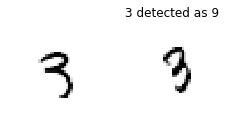

In [260]:
## y_ind = np.arange(10000)
i_arr = np.arange(10)
y_ind = np.arange(10000)
i_arr = np.arange(10)
i = 3
j = 9
j_matr = result_matrix_6 == i
curr = y_pred == j
i_matr = y_test == i
i_rec = y_ind[curr * j_matr * i_matr]
fig = plt.figure()
#z = np.arange(np.size(i_rec))
#np.random.shuffle(z)
#i_rec_9 = i_rec[z[:10]]
for j in range(1, min(np.size(i_rec) + 1, 10)):
    ax = fig.add_subplot(3, 3, j)
    plt.imshow(X_test[i_rec[j - 1]].reshape(28, 28), cmap="Greys")
    plt.axis('off')
fig.suptitle('3 detected as 9')
fig.savefig('gauss_1.pdf')

9